## feature ranking with elimination

In [1]:
from pathlib import Path

In [2]:
import csv
import time  # Just to compare fit times
from pathlib import Path
from pprint import pprint
import csv
import multiprocessing

In [3]:
import numpy as np
# import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
# from tune_sklearn import TuneSearchCV
# from xgboost import XGBRegressor
# import xgboost as xgb


In [4]:
input_dataset_path = Path('../../data/input_dataset.csv')

In [5]:
%%time

# read the csv file created
train = np.genfromtxt(input_dataset_path, delimiter=',',skip_header=1)


X, y = train[:, 1:], train[:, :1]
y = y.ravel()

# Set training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

CPU times: user 16.8 s, sys: 1.05 s, total: 17.8 s
Wall time: 17.9 s


In [6]:
headers = next(csv.reader(open(input_dataset_path)))
pprint(headers)

['target',
 'LOC_distance_to_coast',
 'mrvbf_9',
 'relief_mrvbf_3s_mosaic',
 'relief_elev_focalrange1000m_3s',
 'relief_elev_focalrange300m_3s',
 'saga_wetSM_85_resampled',
 'tpi_300',
 'slope_fill2',
 'dem_fill',
 '3dem_mag2',
 '3dem_mag1_fin',
 '3dem_mag0.fin',
 'relief_roughness',
 'LATITUDE_GRID1_clip',
 'Dose_2016',
 'Potassium_2016',
 'Thorium_2016',
 'Rad2016U_Th',
 'Rad2016K_Th',
 'national_Wii_RF_multirandomforest_prediction',
 'si_geol1',
 'ceno_euc_aust1',
 'Grav_lane_clip',
 'be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata',
 'be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata',
 'be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata',
 'be-30y-85m-avg_BLUE+SWIR2',
 'be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata',
 'be-30y-85m-avg-CLAY-PC2.filled.lzw.nodata',
 'be-30y-85m-avg-RED.filled.lzw.nodata',
 'be-30y-85m-avg-GREEN.filled.lzw.nodata',
 'be-l8-all-85m-avg-BLUE.filled.lzw.nodata',
 'be-l8-all-85m-avg-NIR.filled.lzw.nodata',
 'be-30y-85m-avg-SWIR1.filled.lzw.nodata',
 'be-30y-85m-avg

## Build-in Recursive feature elimination with cross-validation


Optimal number of features : 34


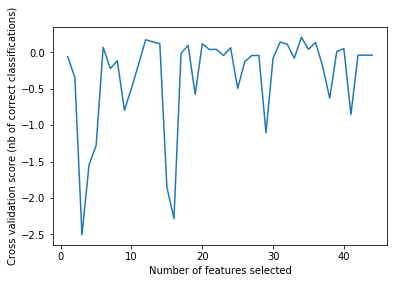

In [19]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV


# Create the RFE object and compute a cross-validated score.
xgb_model = xgb.XGBRegressor(n_jobs=multiprocessing.cpu_count() // 2)

# The "accuracy" scoring is proportional to the number of correct
# classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=xgb_model, 
              step=1, 
              cv=2,
              scoring='r2',
              min_features_to_select=min_features_to_select)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_)
plt.show()

In [21]:
rfecv.support_

array([ True,  True,  True,  True, False,  True, False, False,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True])

In [22]:
rfecv.ranking_

array([ 1,  1,  1,  1,  4,  1,  7,  8,  1,  1,  1,  9,  2,  1, 11,  1,  1,
        1,  1,  1,  6,  1,  1,  1,  1,  1,  1,  1,  1,  5, 10,  1,  1,  1,
        1,  1,  3,  1,  1,  1,  1,  1,  1,  1])

## In-house Recursive feature elimination with cross-validation

In [24]:


import pandas as pd
import numpy as np
import distributed

import dask
import dask.array as da
import dask.dataframe as dd
from dask.distributed import Client, wait, LocalCluster

from dask_cuda import LocalCUDACluster
from sklearn.model_selection import train_test_split

# from dask_ml.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
# from dask_ml.metrics import r2_score
import xgboost as xgb

# # from sklearn.metrics import  explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# # Start cluster and client. This is currently local, although I would like to make this distributed across many nodes.
# # cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES='0,1,2,3', threads_per_worker=2)
# cluster = LocalCluster(n_workers=24,threads_per_worker=12,dashboard_address='0.0.0.0:8787')
# # cluster = LocalCluster(dashboard_address='0.0.0.0:8787') # Workers: 6, Cores: 24
# # cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES='0,1,2,3', threads_per_worker=24,dashboard_address='0.0.0.0:8787')

# # cluster = LocalCUDACluster()
# client = Client(cluster)
# client



In [25]:
%%time
input_dataset_path = Path('../../data/input_dataset.csv')
# read the csv file created
train = np.genfromtxt(input_dataset_path, delimiter=',',skip_header=1)


X, y = train[:, 1:], train[:, :1]
y = y.ravel()

# Feature Matrix    
# Prep Training/Testing Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=False)
del X
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

del X_train
del X_test
del y_train

# XGBoost model
param = {'objective':'reg:squarederror','eval_metric':'rmse'}
xg_reg = xgb.train(param, dtrain)
y_pred = xg_reg.predict(dtest)

del xg_reg
del dtest
del dtrain

score = mean_squared_error(y_test, y_pred,squared=True )

score

CPU times: user 2min 29s, sys: 1.28 s, total: 2min 30s
Wall time: 21.5 s


0.2981210987803412

In [68]:
%%time
dtrain = xgb.DMatrix('../../data/input_dataset.csv?format=csv&label_column=0')
param = {'objective':'reg:squarederror'}
xgb_cv_results = xgb.cv(params=param, dtrain=dtrain, nfold=2, verbose_eval=False)
best_score = xgb_cv_results.iloc[:,0].values[-1]
best_score

CPU times: user 4min 6s, sys: 841 ms, total: 4min 7s
Wall time: 8.41 s


0.20322

In [69]:
xgb_cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.424712,0.000323,0.425974,0.000740
1,0.352768,0.000438,0.355820,0.001032
2,0.307128,0.000672,0.311422,0.000197
3,0.274613,0.000359,0.280563,0.000135
4,0.254083,0.001494,0.261242,0.001319
5,0.236872,0.000205,0.245351,0.000087
6,0.227658,0.001471,0.237310,0.001392
7,0.220212,0.001318,0.230944,0.000880
8,0.207805,0.001210,0.219908,0.001512
9,0.203220,0.001053,0.216091,0.001348


In [73]:
%%time
df = pd.read_csv('../../data/input_dataset.csv')

X = df.drop("target",axis=1)   # Feature Matrix
y = df["target"]    
features_to_drop = "LOC_distance_to_coast"
#--------------------------------
dtrain = xgb.DMatrix(data=X.drop(features_to_drop,axis=1), label=y,nthread=-1)

param = {
    'objective':'reg:squarederror',
    'tree_method':'approx',
    'predictor': 'cpu_predictor'
}
xgb_cv_results = xgb.cv(param, dtrain,nfold=3,metrics="rmsle",verbose_eval=False,seed=0)
best_score = xgb_cv_results.iloc[:,0].values[-1]
best_score

CPU times: user 6min 4s, sys: 2.44 s, total: 6min 7s
Wall time: 11.1 s


0.10831833333333334

In [75]:
def get_score_without_feature(X, y, features_to_drop):
    
    dtrain = xgb.DMatrix(data=X.drop(features_to_drop,axis=1), label=y,nthread=-1)

    param = {
        'objective':'reg:squarederror',
        'tree_method':'approx',
        'predictor': 'cpu_predictor'
    }
    xgb_cv_results = xgb.cv(param, dtrain,nfold=3,metrics="rmsle",verbose_eval=False,seed=0)
    best_score = xgb_cv_results.iloc[:,0].values[-1]
    return best_score
    

In [81]:
# %%time
# df = pd.read_csv('../../data/input_dataset.csv')

# X = df.drop("target",axis=1)   # Feature Matrix
# y = df["target"]    
# #----------------------------------
# intermediate_results = {}
# for featureindex,feature_name in enumerate(X.columns):
#     print("Getting score for: ",feature_name)
#     score_without_feature = get_score_without_feature(X, y, feature_name)
#     intermediate_results[feature_name] = score_without_feature
    

# # calculate the results        
# lowest_feature = None
# lowest_score = -999
# for feature_name in intermediate_results.keys():
#     score_without_feature = intermediate_results[feature_name]
#     if score_without_feature >= lowest_score:
#         lowest_score = score_without_feature
#         lowest_feature = feature_name

        
# lowest_score,lowest_feature

Getting score for:  LOC_distance_to_coast
CPU times: user 2min 31s, sys: 1.84 s, total: 2min 33s
Wall time: 6.45 s


(0.10831833333333334, 'LOC_distance_to_coast')

In [82]:
import time


def find_least_important_feature(X, y):
        
    intermediate_results = {}
    for featureindex,feature_name in enumerate(X.columns):
        score_without_feature = get_score_without_feature(X, y, feature_name)
        intermediate_results[feature_name] = score_without_feature
        print("Getting score for: ",feature_name,score_without_feature,len(X.columns))
           
    # calculate the results        
    lowest_feature = None
    lowest_score = -999
    for feature_name in intermediate_results.keys():
        score_without_feature = intermediate_results[feature_name]
        if score_without_feature >= lowest_score:
            lowest_score = score_without_feature
            lowest_feature = feature_name
        del score_without_feature
    del intermediate_results
    return(lowest_score,lowest_feature)

In [83]:
%%time

df = pd.read_csv('../../data/input_dataset.csv')

X = df.drop("target",axis=1)   # Feature Matrix
y = df["target"]    

min_features_required = 43
complete_result = {}
results = []

current_total_feature = X.shape[1]
complete_result[current_total_feature] = {}

lowest_score,lowest_feature = find_least_important_feature(X,y)
lowest_score,lowest_feature
results.append((lowest_score,lowest_feature))
print(lowest_score,lowest_feature)

current_X = X.drop(lowest_feature,axis=1)   
current_total_feature = X.shape[1]

while(current_total_feature>min_features_required):

    lowest_score,lowest_feature = find_least_important_feature(current_X,y)
    results.append((lowest_score,lowest_feature))
    current_X = current_X.drop(lowest_feature,axis=1)
    current_total_feature = current_X.shape[1]
    print(lowest_score,lowest_feature)

Getting score for:  LOC_distance_to_coast 0.10831833333333334 42
Getting score for:  mrvbf_9 0.10689233333333333 42
Getting score for:  relief_mrvbf_3s_mosaic 0.10722533333333333 42
Getting score for:  relief_elev_focalrange1000m_3s 0.107698 42
Getting score for:  relief_elev_focalrange300m_3s 0.10727000000000002 42
Getting score for:  saga_wetSM_85_resampled 0.10705733333333334 42
Getting score for:  tpi_300 0.108083 42
Getting score for:  slope_fill2 0.10806433333333332 42
Getting score for:  dem_fill 0.10782266666666666 42
Getting score for:  3dem_mag2 0.10929433333333333 42
Getting score for:  3dem_mag1_fin 0.10820733333333332 42
Getting score for:  3dem_mag0.fin 0.10806 42
Getting score for:  relief_roughness 0.107684 42
Getting score for:  LATITUDE_GRID1_clip 0.10735866666666666 42
Getting score for:  Dose_2016 0.10787200000000001 42
Getting score for:  Potassium_2016 0.10775666666666667 42
Getting score for:  Thorium_2016 0.10862933333333334 42
Getting score for:  Rad2016U_Th 0.

## Shutdown Cluster


In [ ]:
client = distributed.client._get_global_client()
client

In [13]:
client.shutdown()

{'cols_to_drop': [0],
 'feature_to_drop': 0,
 'n': 0,
 'regression_results': {'MAE': 0.0625,
                        'MSE': 0.0303,
                        'RMSE': 0.174,
                        'explained_variance': 0.8255,
                        'r2': 0.8255}}


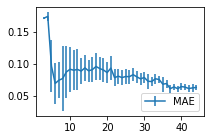

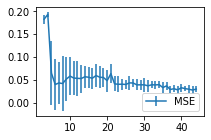

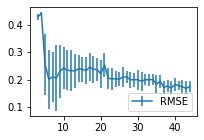

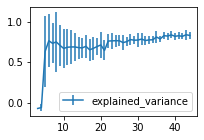

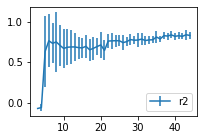

In [60]:
import numpy as np
import matplotlib.pyplot as plt
    

    

scorings = ['MAE','MSE','RMSE','explained_variance','r2']
total_number_of_features = X.shape[1]
# minimum_features_constraint = 3

for scoring in scorings:    
    x = []
    ymax = []
    ymin = []
    y = []
    yerr = []

    for i in range(45):
        x.append(i)
        y.append(0)
        ymax.append(-9999)
        ymin.append(9999)
        yerr.append(0)

    for result in results_xgb:
        index = total_number_of_features-result["n"]
        y[index] = result["regression_results"][scoring]


        if result["regression_results"][scoring] > ymax[index]:
            ymax[index] = result["regression_results"][scoring]

        if result["regression_results"][scoring] < ymin[index]:
            ymin[index] = result["regression_results"][scoring]

    for i in range(45):
        yerr[i] = ymax[i] - ymin[i]


    x = x[3:]
    ymax = ymax[3:]
    ymin = ymin[3:]
    y = y[3:]
    yerr = yerr[3:]


    fig = plt.figure()

    w=3
    h=2
    fig.set_size_inches(w, h)

    plt.errorbar(x, y, yerr=yerr, label=scoring)
    plt.legend(loc='lower right')